# Transformer Network Application: Question Answering

Question answering (QA) is a task of natural language processing that aims to automatically answer questions. The goal of *extractive* QA is to identify the portion of the text that contains the answer to a question. For example, when tasked with answering the question 'When will Jane go to Africa?' given the text data 'Jane visits Africa in September', the question answering model will highlight 'September'.


<font color='blue'>Approach:  
* Perform extractive Question Answering 
* Fine-tune a pre-trained transformer model to a custom dataset
* Implement a QA model in TensorFlow and PyTorch

## Data preprocessing

Run the following cell to load the [QA bAbI dataset](https://research.fb.com/downloads/babi/), which is one of the bAbI datasets generated by Facebook AI Research to advance natural language processing.

In [33]:
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_from_disk

In [34]:
# Load a dataset and print the first example in the training set
babi_dataset = load_from_disk('data/nlp_qa/')

In [35]:
babi_dataset.keys()

dict_keys(['train', 'test'])

In [37]:
babi_dataset['train'].shape, babi_dataset['test'].shape

((1000, 1), (1000, 1))

In [4]:
babi_dataset['train'][0]

{'story': {'answer': ['', '', 'office'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['1']],
  'text': ['The office is north of the kitchen.',
   'The garden is south of the kitchen.',
   'What is north of the kitchen?'],
  'type': [0, 0, 1]}}

In [5]:
babi_dataset['train'][1]

{'story': {'answer': ['', '', 'kitchen'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['1']],
  'text': ['The kitchen is west of the garden.',
   'The hallway is west of the kitchen.',
   'What is the garden east of?'],
  'type': [0, 0, 1]}}

In [6]:
example = babi_dataset['train'][1]
example['story']['type']

[0, 0, 1]

In [7]:
# Check and see if the entire dataset of stories has this format.

type_set = set()
for example in babi_dataset['train']:
    if str(example['story']['type']) not in type_set:
        type_set.add(str(example['story']['type'] ))
type_set

{'[0, 0, 1]'}

In [8]:
# To make the data easier to work with,
# flatten the dataset to transform it from a dictionary structure to a table structure.

flat_babi = babi_dataset.flatten()
flat_babi

DatasetDict({
    train: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
})

In [9]:
flat_babi['train'][1]

{'story.answer': ['', '', 'kitchen'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The kitchen is west of the garden.',
  'The hallway is west of the kitchen.',
  'What is the garden east of?'],
 'story.type': [0, 0, 1]}

In [10]:
def get_question_and_facts(m):
    dic = {}
    dic['question'] = m['story.text'][2]
    dic['sentences'] = ' '.join([m['story.text'][0], m['story.text'][1]])
    dic['answer'] = m['story.answer'][2]
    return dic

In [11]:
processed = flat_babi.map(get_question_and_facts)

Parameter 'function'=<function get_question_and_facts at 0x000002036C7E6438> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [12]:
processed['train'][2]

{'answer': 'bedroom',
 'question': 'What is north of the garden?',
 'sentences': 'The garden is north of the office. The bedroom is north of the garden.',
 'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The garden is north of the office.',
  'The bedroom is north of the garden.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1]}

The goal of extractive QA is to find the **part of the text** that contains the answer to the question. We will identify the position of the answer using start and end string indices of the string. 

In [13]:
def get_start_end_idx(m):
    str_idx = m['sentences'].find(m['answer'])
    end_idx = str_idx + len(m['answer'])
    return {'str_idx':str_idx, 'end_idx': end_idx}

In [14]:
processed = processed.map(get_start_end_idx)

In [15]:
processed['train'][2]

{'answer': 'bedroom',
 'end_idx': 46,
 'question': 'What is north of the garden?',
 'sentences': 'The garden is north of the office. The bedroom is north of the garden.',
 'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The garden is north of the office.',
  'The bedroom is north of the garden.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'str_idx': 39}

In [16]:
processed['train'][2]['sentences'].find('bedroom')

39

In [17]:
processed.shape

{'train': (1000, 10), 'test': (1000, 10)}

## Tokenize and Align with 🤗 Library

Now we have all the data to train a Transformer model to perform Question Answering! 
* To feed text data to a Transformer model, we will need to tokenize the input using a [🤗 Transformer tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html). 
* It is crucial that the tokenizer we use must match the Transformer model type we are using - 🤗 [DistilBERT fast tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html), in this case, which standardizes the length of sequence to 512 and pads with zeros.

**Operational Note**: Transformer models are often trained by tokenizers that split words into subwords. For instance, the word 'Africa' might get split into multiple subtokens. This can create some misalignment between the list of tags for the dataset and the list of labels generated by the tokenizer, since the tokenizer can split one word into several, or add special tokens. Before processing, it is important that we align the start and end indices with the tokens associated with the target answer word with a `tokenize_and_align()` function. In this case, since we are interested in the start and end indices of the answer, we will want to align the index of the sentence to match the index of the token for a word.

In [18]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('pretrainedmodel/nlp_transformer/tokenizer/')

In [19]:
def tokenize_align(example):
    encoding = tokenizer(example['sentences'], example['question'], truncation=True, 
                         padding=True, max_length=tokenizer.model_max_length)
    start_positions = encoding.char_to_token(example['str_idx'])
    end_positions = encoding.char_to_token(example['end_idx']-1)
    if start_positions is None:
        start_positions = tokenizer.model_max_length
    if end_positions is None:
        end_positions = tokenizer.model_max_length
    
    return {'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'start_positions': start_positions,
            'end_positions': end_positions}

In [20]:
# What does the function do?
temp = processed['train'][0]
display(temp)

encoding = tokenizer(temp['sentences'], temp['question'], truncation=True, 
                         padding=True, max_length=tokenizer.model_max_length)
start_positions = encoding.char_to_token(temp['str_idx'])
end_positions = encoding.char_to_token(temp['end_idx']-1)
print(temp['str_idx'], temp['end_idx']-1)
print(start_positions, end_positions)
print(encoding)

{'answer': 'office',
 'end_idx': 10,
 'question': 'What is north of the kitchen?',
 'sentences': 'The office is north of the kitchen. The garden is south of the kitchen.',
 'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1],
 'str_idx': 4}

4 9
2 2
{'input_ids': [101, 1996, 2436, 2003, 2167, 1997, 1996, 3829, 1012, 1996, 3871, 2003, 2148, 1997, 1996, 3829, 1012, 102, 2054, 2003, 2167, 1997, 1996, 3829, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [21]:
qa_dataset = processed.map(tokenize_align)

In [22]:
qa_dataset = qa_dataset.remove_columns(['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'])

In [23]:
qa_dataset['train'][0]
# Kitchen = 3829, North = 2167, Is = 2003, The = 1996, Of = 1997, '.' = 1012, "'" = 101/102
# answer = 'office' which is at index=2

{'answer': 'office',
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'end_idx': 10,
 'end_positions': 2,
 'input_ids': [101,
  1996,
  2436,
  2003,
  2167,
  1997,
  1996,
  3829,
  1012,
  1996,
  3871,
  2003,
  2148,
  1997,
  1996,
  3829,
  1012,
  102,
  2054,
  2003,
  2167,
  1997,
  1996,
  3829,
  1029,
  102],
 'question': 'What is north of the kitchen?',
 'sentences': 'The office is north of the kitchen. The garden is south of the kitchen.',
 'start_positions': 2,
 'str_idx': 4}

## Loading Pre-trained Model

Now that we've finished tokenizing and aligning data, it can be fed to a pre-trained 🤗 Transformer model - we use a **DistilBERT model**, which matches the tokenizer used to preprocess your data.

In [24]:
train_ds = qa_dataset['train']
test_ds = qa_dataset['test']

In [25]:
from transformers import TFDistilBertForQuestionAnswering
model = TFDistilBertForQuestionAnswering.from_pretrained('pretrainedmodel/nlp_transformer/DistilBertQATF', 
                                                         return_dict=False)

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at pretrainedmodel/nlp_transformer/DistilBertQATF.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


## TensorFlow Implementation

**Operational Note**:
* In the TensorFlow implementation, we will have to set the data format type to tensors, which may create ragged tensors (tensors of different lengths). 
* We will have to convert the ragged tensors to normal tensors using the `to_tensor()` method, which pads the tensors and sets the dimensions to `[None, tokenizer.model_max_length]` so we can feed different size tensors into the model based on the batch size.  

In [52]:
columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']

train_ds.set_format(type='tf', columns=columns_to_return)

train_features = {x: train_ds[x].to_tensor(default_value=0, shape=[None, tokenizer.model_max_length])
                  for x in ['input_ids', 'attention_mask']}
train_labels = {"start_positions": tf.reshape(train_ds['start_positions'], shape=[-1,1]),
                'end_positions': tf.reshape(train_ds['end_positions'], shape=[-1,1])}

train_tfdataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)

## Training

**Operational Note**:
* Create a custom training function using tf.GradientTape() - it records the operations performed during forward prop for automatic differentiation during backprop.
* Target two loss functions, one for the start index and one for the end index.

In [53]:
EPOCHS = 3
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)

losses = []
for epoch in range(EPOCHS):
    print("Starting epoch: %d"% epoch )
    for step, (x_batch_train, y_batch_train) in enumerate(train_tfdataset):
        with tf.GradientTape() as tape:
            answer_start_scores, answer_end_scores = model(x_batch_train)
            loss_start = loss_fn1(y_batch_train['start_positions'], answer_start_scores)
            loss_end   = loss_fn2(y_batch_train['end_positions']  , answer_end_scores)
            loss = 0.5 * (loss_start + loss_end)
        losses.append(loss)
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))

        if step % 20 == 0:
            print("Training loss (for one batch) at step %d: %.4f"% (step, 
                                                                   float(loss_start)))

Starting epoch: 0
Training loss (for one batch) at step 0: 6.4653
Training loss (for one batch) at step 20: 1.3122
Training loss (for one batch) at step 40: 0.9882
Training loss (for one batch) at step 60: 0.8768
Training loss (for one batch) at step 80: 0.5850
Training loss (for one batch) at step 100: 0.2007
Training loss (for one batch) at step 120: 0.6216
Starting epoch: 1
Training loss (for one batch) at step 0: 0.6460
Training loss (for one batch) at step 20: 0.1893
Training loss (for one batch) at step 40: 0.5078
Training loss (for one batch) at step 60: 0.3546
Training loss (for one batch) at step 80: 0.1946
Training loss (for one batch) at step 100: 0.0993
Training loss (for one batch) at step 120: 0.4973
Starting epoch: 2
Training loss (for one batch) at step 0: 0.4075
Training loss (for one batch) at step 20: 0.2040
Training loss (for one batch) at step 40: 0.5305
Training loss (for one batch) at step 60: 0.2548
Training loss (for one batch) at step 80: 0.1245
Training loss 

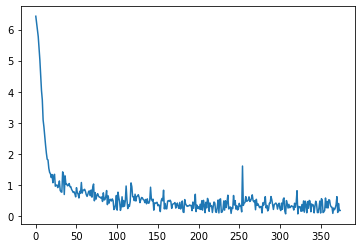

In [57]:
plt.plot(losses)

---
## PyTorch implementation

[PyTorch](https://pytorch.org/) is an open source machine learning framework developed by Facebook's AI Research lab that can be used for computer vision and natural language processing.

### Train and test dataset

In [40]:
train_ds.shape

(1000, 9)

In [43]:
train_ds[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]),
 'end_positions': tensor(2),
 'input_ids': tensor([ 101, 1996, 2436, 2003, 2167, 1997, 1996, 3829, 1012, 1996, 3871, 2003,
         2148, 1997, 1996, 3829, 1012,  102, 2054, 2003, 2167, 1997, 1996, 3829,
         1029,  102]),
 'start_positions': tensor(2)}

In [26]:
from torch.utils.data import DataLoader

columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']
train_ds.set_format(type='pt', columns=columns_to_return)   # type = pytorch, tensorflow, numpy etc.
test_ds.set_format(type='pt', columns=columns_to_return)

For the accuracy metrics for the PyTorch implementation, we will use F1 score

In [27]:
from sklearn.metrics import f1_score

def compute_metrics(pred):
    start_labels = pred.label_ids[0]
    end_labels   = pred.label_ids[1]
    start_preds  = pred.predictions[0].argmax(-1)
    end_preds    = pred.predictions[1].argmax(-1)
    
    f1_start = f1_score(start_labels, start_preds, average='macro')
    f1_end   = f1_score(end_labels, end_preds, average='macro')
    
    return {'f1_start': f1_start,
            'f1_end': f1_end}

In [28]:
del model # We delete the tensorflow model to avoid memory issues

In [29]:
from transformers import DistilBertForQuestionAnswering

pytorch_model = DistilBertForQuestionAnswering.from_pretrained("pretrainedmodel/nlp_transformer/DistilBertQApytorch")

Instead of a custom training loop, you will use the [🤗 Trainer](https://huggingface.co/transformers/main_classes/trainer.html), which contains a basic training loop and is fairly easy to implement in PyTorch.

In [30]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='results',            # output directory
    overwrite_output_dir=True,
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=20,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=None,                # directory for storing logs
    logging_steps=50
)

trainer = Trainer(
    model=pytorch_model,                 # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_ds,              # training dataset
    eval_dataset=test_ds,
    compute_metrics=compute_metrics      # evaluation dataset
)

trainer.train()

Step,Training Loss
50,1.529700
100,0.696400
150,0.521400
200,0.416300
250,0.337700
300,0.404200
350,0.301300


TrainOutput(global_step=375, training_loss=0.5834623311360677, metrics={'train_runtime': 233.4976, 'train_samples_per_second': 1.606, 'total_flos': 31058547624000, 'epoch': 3.0})

In [31]:
trainer.evaluate(test_ds)

{'eval_loss': 0.31048983335494995,
 'eval_f1_start': 0.8231819375164086,
 'eval_f1_end': 0.8175549301161046,
 'eval_runtime': 13.8539,
 'eval_samples_per_second': 72.182,
 'epoch': 3.0}

Now it is time to ask the PyTorch model a question! 
* Before testing the model with a question, we can tell PyTorch to send our model and inputs to the GPU if the machine has one, or the CPU if it does not. 
* We can then proceed to tokenize the input and create PyTorch tensors and send them to the device. 
* The rest of the pipeline is relatively similar to the one we implemented for TensorFlow.   


In [44]:
torch.cuda.is_available()

False

In [58]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
pytorch_model.to(device);

In [83]:
text     = 'The balcony is east of the hallway. The garden is south of the bedroom.'
question = 'What is east of the hallway?'

input_dict = tokenizer(text, question, return_tensors='pt')

input_ids      = input_dict['input_ids'].to(device)
attention_mask = input_dict['attention_mask'].to(device)

In [84]:
input_ids

tensor([[  101,  1996, 11673,  2003,  2264,  1997,  1996,  6797,  1012,  1996,
          3871,  2003,  2148,  1997,  1996,  5010,  1012,   102,  2054,  2003,
          2264,  1997,  1996,  6797,  1029,   102]])

In [85]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])

In [86]:
outputs = pytorch_model(input_ids, attention_mask=attention_mask)

start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[torch.argmax(start_logits, 1)[0] : torch.argmax(end_logits, 1)[0]+1])

print(question, answer.capitalize())

What is east of the hallway? Balcony


<font color='blue'><b>Takeaways:</b>
- Transformer models are often trained by tokenizers that split words into subwords.
  - Before processing, it is important to align the start and end indices with the tokens associated with the target answer word.
- PyTorch is a relatively light and easy to implement framework that can make rapid prototyping easier, while TensorFlow has advantages in scaling and is more widely used in production
  - `tf.GradientTape` allows us to build custom training loops in TensorFlow
  - The `Trainer` API in PyTorch gives a basic training loop that is compatible with 🤗 models and datasets